# Business Context
You’re working for a mid-sized telecom company (let’s call it TelCoX). The marketing team is worried because customer churn (customers canceling their subscriptions) has been creeping up to ~18% annually. Every 1% reduction in churn could save the company millions in revenue. The VP of Customer Retention has asked the data science team:

#### “Can we predict which customers are likely to churn in the next 3 months so we can proactively offer them retention incentives?”

# 1. Problem definition & Success Metrics:

* Problem definition: Find potential customer getting churned in next 3 months

* Metrics: Find recall to get potential customer getting churned

# 2. Data loading & exploration (EDA)

In [1]:
import pandas as pd


In [3]:
df = pd.read_csv("Customer-Churn.csv")

In [4]:
# Basic info
print(df.shape)
print(df.head())
print(df.info())
print(df['Churn'].value_counts(normalize=True))

(7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Co

In [5]:
# Check why it's object
print(df['TotalCharges'].head(10))
print(df['TotalCharges'].dtype)

# Convert, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check missing values now
print(df.isnull().sum())

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
5      820.5
6     1949.4
7      301.9
8    3046.05
9    3487.95
Name: TotalCharges, dtype: object
object
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [6]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'])

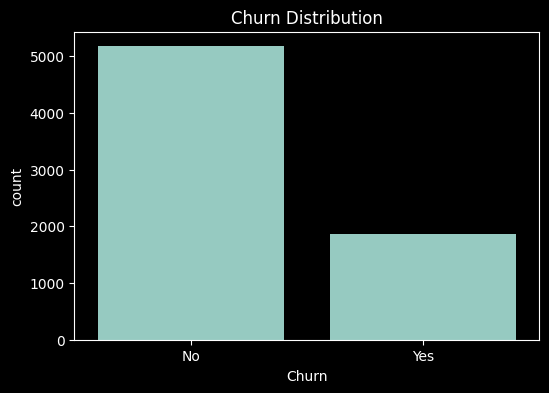

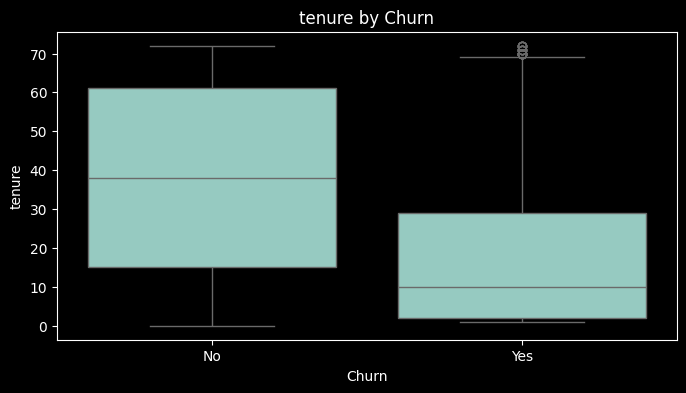

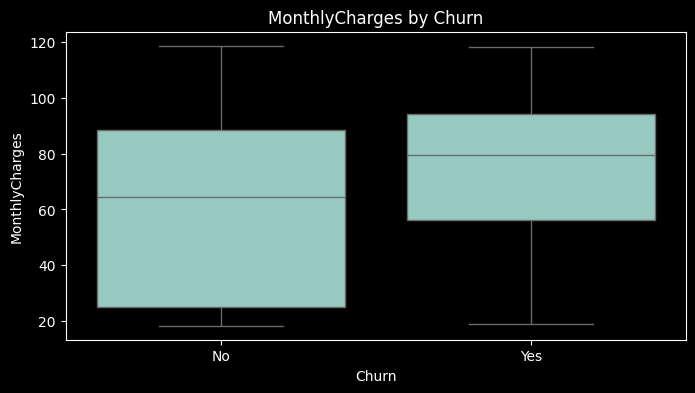

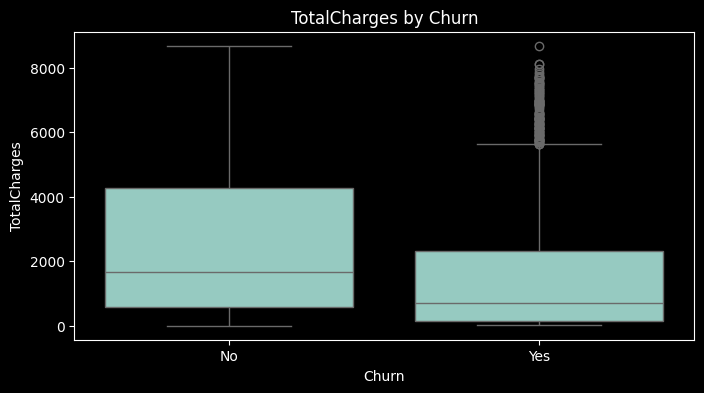

<Figure size 800x400 with 0 Axes>

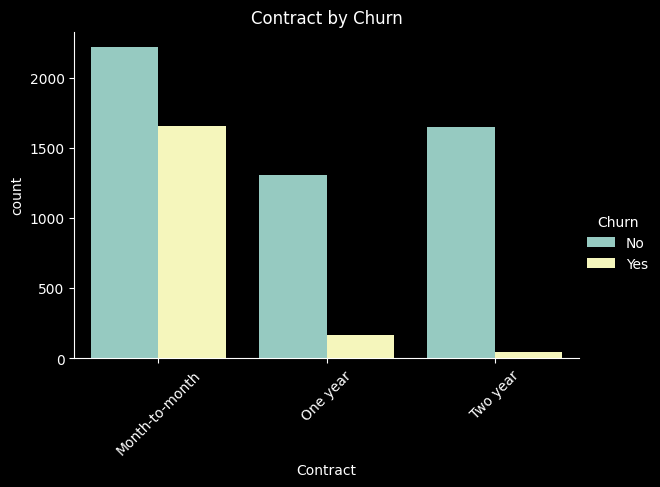

<Figure size 800x400 with 0 Axes>

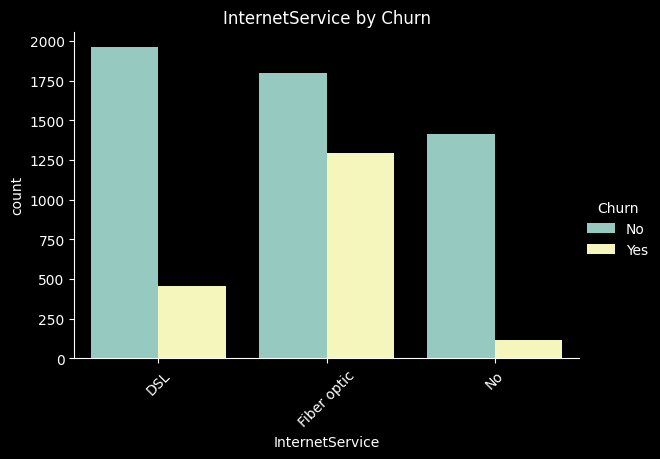

<Figure size 800x400 with 0 Axes>

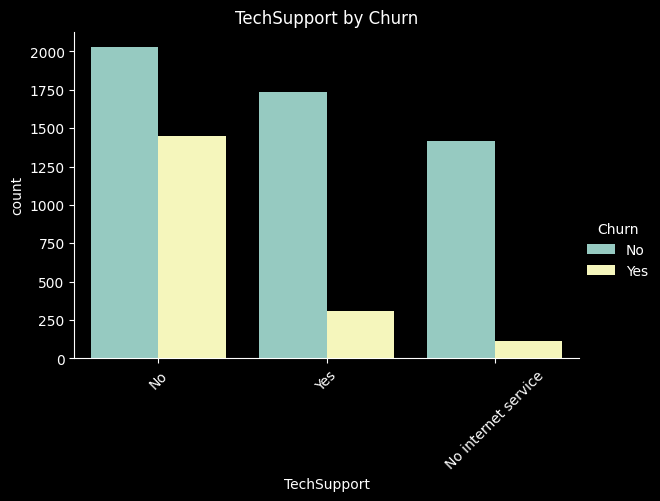

<Figure size 800x400 with 0 Axes>

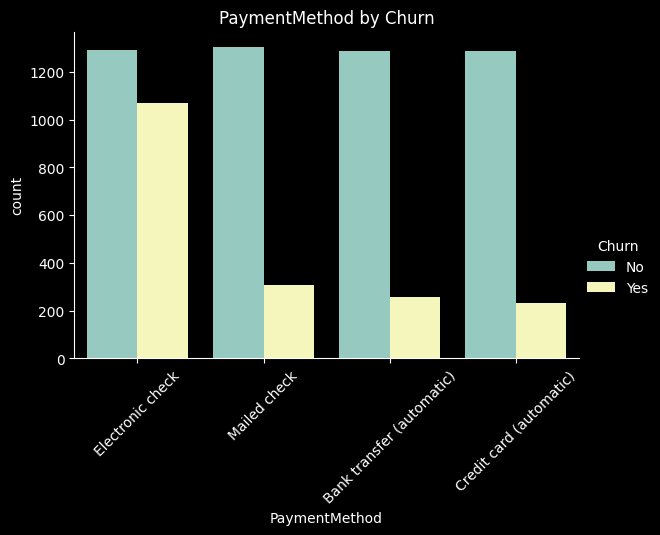

<Figure size 800x400 with 0 Axes>

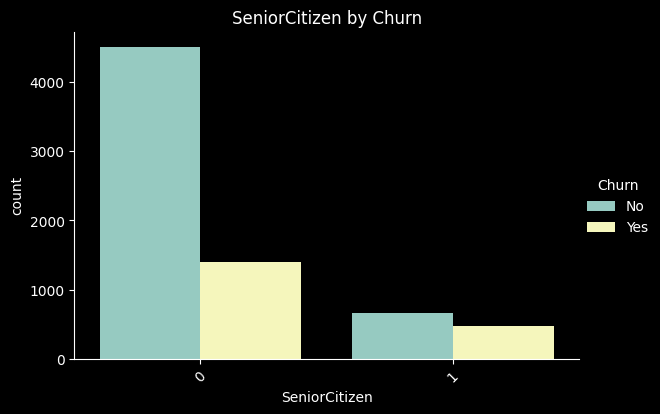

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Churn distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution')
plt.show()

# Numerical features vs Churn
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x='Churn', y=col)
    plt.title(f'{col} by Churn')
    plt.show()

# Some key categorical vs Churn
cat_cols = ['Contract', 'InternetService', 'TechSupport', 'PaymentMethod', 'SeniorCitizen']
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.catplot(data=df, x=col, hue='Churn', kind='count', height=4, aspect=1.5)
    plt.title(f'{col} by Churn')
    plt.xticks(rotation=45)
    plt.show()

##### Observations:

- New customers churn much more.
- Customers paying more per month are more likely to leave.
- Customers without long-term commitment churn way more.
- Fiber optic internet service has higher churn
- No tech support → high churn
- Electronic check payment method → higher churn

# 3. Data cleaning & feature engineering

In [9]:
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"])
# Check missing values now
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


# 4. Baseline modeling

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Logistic Regression baseline
lr = LogisticRegression(max_iter=10000, random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print(classification_report(y_test, lr_pred))
print("AUC:", roc_auc_score(y_test, lr_proba))

# Random Forest baseline
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest")
print(classification_report(y_test, rf_pred))
print("AUC:", roc_auc_score(y_test, rf_proba))

Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

AUC: 0.8425275775659407

Random Forest
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

AUC: 0.8284197473455785


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Drop customerID - useless for modeling
df = df.drop('customerID', axis=1)

# Convert binary categories to 0/1
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Gender separate
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})

# SeniorCitizen is already 0/1

# One-hot encode multi-category nominal features
cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
            'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Target and features
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split (80/20, stratified because imbalanced)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape)

(5634, 30) (1409, 30)


In [16]:
top_features = rf.feature_importances_
top_features = pd.Series(top_features, index=X.columns)
top_features = top_features.sort_values(ascending=False)
print(top_features)


TotalCharges                             0.203400
MonthlyCharges                           0.171730
tenure                                   0.163415
PaymentMethod_Electronic check           0.040043
InternetService_Fiber optic              0.038527
gender                                   0.027973
Contract_Two year                        0.027955
PaperlessBilling                         0.026668
OnlineSecurity_Yes                       0.023737
TechSupport_Yes                          0.023623
Partner                                  0.023501
OnlineBackup_Yes                         0.022336
Contract_One year                        0.022162
SeniorCitizen                            0.020652
Dependents                               0.019909
DeviceProtection_Yes                     0.019789
MultipleLines_Yes                        0.019501
StreamingTV_Yes                          0.017637
StreamingMovies_Yes                      0.017495
PaymentMethod_Credit card (automatic)    0.013367


# 5. Evaluation & business interpretation

In [17]:
# Logistic Regression coefficients
lr_coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(lr_coefs.head(10))

                           Feature  Coefficient
26               Contract_Two year    -1.322491
11     InternetService_Fiber optic     1.278785
25               Contract_One year    -0.680268
22                 StreamingTV_Yes     0.413516
24             StreamingMovies_Yes     0.411905
10               MultipleLines_Yes     0.382938
28  PaymentMethod_Electronic check     0.382903
6                 PaperlessBilling     0.372202
14              OnlineSecurity_Yes    -0.326903
9   MultipleLines_No phone service     0.285310


Below are some lower churn risk features:

- Contract_Two year    -1.322491

- Contract_One year    -0.680268

- OnlineSecurity_Yes    -0.326903

Below are some features which had higher churn risk:

- InternetService_Fiber optic     1.278785

- StreamingTV_Yes     0.413516

- StreamingMovies_Yes     0.411905

- MultipleLines_Yes     0.382938

- PaymentMethod_Electronic check     0.382903

- PaperlessBilling     0.372202

- MultipleLines_No phone service     0.285310


In [18]:
test_probs = pd.DataFrame({
    'actual_churn': y_test.values,
    'predicted_prob_churn': lr_proba
}).reset_index(drop=True)

# Example: Top 10 highest-risk customers
print(test_probs.sort_values('predicted_prob_churn', ascending=False).head(10))

      actual_churn  predicted_prob_churn
1090             1              0.853964
1221             1              0.830730
1175             1              0.826841
1164             1              0.820331
1109             1              0.818252
889              0              0.817138
647              1              0.815853
627              1              0.815851
1138             1              0.814357
1355             0              0.811873


# 6. Next steps / recommendations

Try to focus on retaining


Below are some features which had higher churn risk:

- InternetService_Fiber optic     1.278785

- StreamingTV_Yes     0.413516

- StreamingMovies_Yes     0.411905

- MultipleLines_Yes     0.382938

- PaymentMethod_Electronic check     0.382903

- PaperlessBilling     0.372202

- MultipleLines_No phone service     0.285310


#### Top 3 Business Recommendations for Retention Team
Here are the most impactful, realistic recommendations you could present to the VP of Customer Retention based on our model + EDA:

##### Aggressively push long-term contracts (especially 2-year)
→ The single strongest signal in the entire model.
→ Offer meaningful incentives for customers to switch from month-to-month → 1-year → 2-year contracts.
→ Examples:
$50–$100 one-time bill credit
Free premium channels for 6 months
Discounted monthly rate locked in for 2 years
→ Potential impact: Very high — this could move the needle the most.

##### Investigate and fix the Fiber Optic experience
→ Fiber customers have much higher churn risk even after controlling for price, tenure, etc.
→ Possible root causes:
Installation issues
Speed/reliability complaints
Higher expectations not being met
→ Actions:
Run a targeted Net Promoter Score (NPS) survey only for fiber customers
Check support ticket volume and resolution time for fiber vs DSL
Consider offering free tech support or speed guarantee to fiber customers for the first 6–12 months

###### Targeted retention offers for high-risk segments
Create micro-segments and proactively reach out before they cancel:

High-Risk Segment -> Suggested Proactive Action -> Priority
Month-to-month + Fiber optic + High monthly charges -> Offer 1-year or 2-year contract discount + free months of streaming -> ★★★★★

Electronic check payers + short tenure -> Offer to switch to auto-debit/credit card + $20 credit -> ★★★★

StreamingTV/Movies subscribers (both Yes) -> Check if they actually use the add-on offer to downgrade or bundle better -> ★★★

No phone service (internet-only) -> Bundle cheap basic phone line or offer loyalty discount -> ★★★

Churn Risk Score =

+3 if month-to-month

+2 if fiber optic

+1 if electronic check

+1 if no online security

+1 if high monthly charges (> average)

-2 if 2-year contract

-1 if 1-year contract

In [19]:
import joblib
joblib.dump(lr, 'churn_model_v1.pkl')

['churn_model_v1.pkl']